# suggest_videos

* 歌動画を適当な推薦アルゴリズムを使って推薦します

In [1]:
# Pythonの基本ライブラリ
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ファイル操作
import os
import glob

# Jupyter上にHTMLを表示する
from IPython.display import HTML

from sklearn.manifold import TSNE

In [3]:
# trainsetから動画を取得する
file_select = 'okakoro'
comments = pd.read_csv('output/train/'+file_select+'/comments.csv', index_col=0)
print("全動画数:", comments.shape[0])
comments.head(3)

全動画数: 18


,Id,Channel,Date,Title,Thumbnail,ViewCount,CommentIds
0,JqwKeddXPOg,Okayu Ch. 猫又おかゆ,2021-07-09T12:00:15Z,p.h. / 猫又おかゆ(cover),https://i.ytimg.com/vi/JqwKeddXPOg/hqdefault.jpg,2152671,"UCNmpH2fGPKXBgzfn61kgvfA,UCSp2axqTjK1yH2RZclbx..."
1,G49bAinM6Lc,Korone Ch. 戌神ころね,2020-02-22T12:15:11Z,恋愛裁判 Ver.戌神ころね,https://i.ytimg.com/vi/G49bAinM6Lc/hqdefault.jpg,6802711,"UCED6sLuOSEdCGYHvooJPiEg,UCesNuEgizYMsZtXVqUH4..."
2,4muYzftomAE,Okayu Ch. 猫又おかゆ,2020-08-28T11:00:12Z,flos / 猫又おかゆ (Cover),https://i.ytimg.com/vi/4muYzftomAE/hqdefault.jpg,9069389,"UC6CLbB0QauN9dt0hSwRHHLA,UCRtbrsH49ovOhYAyVKLv..."


In [6]:
# コメントしているChannelIdを数値に変換
unique_ids_tmp = []
for i, row in comments.iterrows():    
    comment_ids_string = row['CommentIds']
    comment_ids = comment_ids_string.split(',')
    unique_ids_tmp.append(comment_ids)

unique_ids = [item for l in unique_ids_tmp for item in l]
unique_ids = np.array(list(set(unique_ids)))
n = unique_ids.shape[0]
print(n)

28223
1 / 18
2 / 18
3 / 18
4 / 18
5 / 18
6 / 18
7 / 18
8 / 18
9 / 18
10 / 18
11 / 18
12 / 18
13 / 18
14 / 18
15 / 18
16 / 18
17 / 18
18 / 18


In [11]:
# 計算量に無駄が多いので以下などを参考に改良したい
# https://qiita.com/ground0state/items/f516b97c7a8641e474c4
X = []
for i, row in holo_comments.iterrows():
    print(i+1, '/', holo_comments.shape[0])
    zeros = np.zeros(n)
    comment_ids_string = row['CommentIds']
    comment_ids = comment_ids_string.split(',')
    ids = []
    for comment_id in comment_ids:
        ids.append(np.where(unique_ids == comment_id)[0][0])
    ids = np.array(ids)
    zeros[ids] = 1
    X.append(zeros)
X = np.array(X)

1 / 471


KeyError: 'CommentIds'

In [7]:
comment_ids_modified = []
channels_modified = []

# 二件以上コメントを残していないユーザは削除する
X_sum = np.sum(X, axis=0)
useful_ids = np.where(X_sum > 1)[0]
X_modified = X.T[useful_ids].T

for i, row in holo_comments.iterrows():
    comment_id_modified = np.where(X_modified[i] == 1)[0]
    comment_id_modified = comment_id_modified.astype(str)
    comment_id_modified_string = ','.join(comment_id_modified)
    comment_ids_modified.append(comment_id_modified_string)
comment_ids_modified = np.array(comment_ids_modified)

# channelIDも同様に数値化
unique_channels_tmp = np.array(holo_comments['Channel'])
unique_channels = np.array(list(set(unique_channels_tmp)))
n = unique_channels.shape[0]
    
for i, row in holo_comments.iterrows():
    channel = row['Channel']
    channels_modified.append(np.where(unique_channels == channel)[0][0])
channels_modified = np.array(channels_modified)

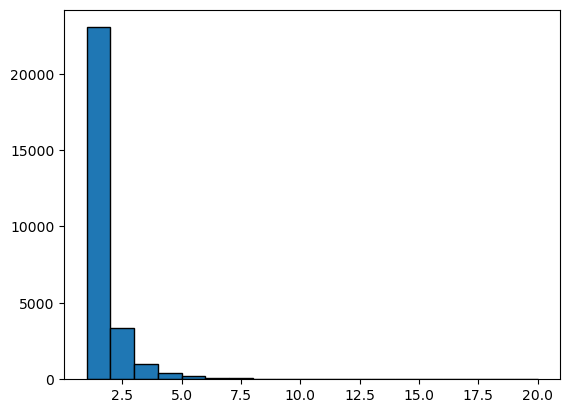

In [8]:
# どれくらい重複があるかを確認したい（重複がなければほぼ効果は無いだろう）
# まぁぼちぼちいそうということでやっていこう
# ただ一件しか動画を見ていない人は協調フィルタリングで役に立つか微妙なので削除する（そうすれば結構小さくなるはず）
X_sum = np.sum(X, axis=0)
 
# ヒストグラム
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.hist(X_sum, bins=np.arange(20)+1, histtype='barstacked', ec='black')
plt.show()
# 20万人いるが、データとして使えそうなのは8万人強

In [9]:
# IDを数値に置き換えたものを保存
holo_comments['ChannelModified'] = channels_modified
holo_comments['CommentIdsModified'] = comment_ids_modified
holo_comments = holo_comments.reset_index()
holo_comments = holo_comments.drop(['CommentIds, index'], axis=1)
holo_comments.to_csv('output/train/holo_comments_modified.csv')

KeyError: "['CommentIds, index'] not found in axis"

In [10]:
# IDを数値に変換したファイルを読み込む
holo_comments = pd.read_csv('output/train/holo_comments_modified.csv', index_col=0)
print("全動画数:", holo_comments.shape[0])
holo_comments.head(50)

全動画数: 471


,Id,Channel,Date,Title,Thumbnail,ViewCount,CommentIdsModified,ChannelModified
0,TnQgSAaGhVc,AZKi Channel,2020-04-30T10:00:11Z,【オリジナルソング】猫ならばいける / AZKi【にゃにゃにゃにゃ】,https://i.ytimg.com/vi/TnQgSAaGhVc/hqdefault.jpg,96721,"167,252,499,1277,1535,1800,2980,2987,3469,3801...",5
1,yk51RdzaMUE,Kanata Ch. 天音かなた,2020-11-01T11:15:10Z,月陽-ツキアカリ-／星街すいせい＆天音かなた(Cover),https://i.ytimg.com/vi/yk51RdzaMUE/hqdefault.jpg,1525776,"20,113,125,126,289,404,407,417,432,515,717,771...",2
2,TyILqS4nF3M,Watame Ch. 角巻わため,2020-09-05T12:15:11Z,chocolate box／角巻わため×天音かなた(Cover),https://i.ytimg.com/vi/TyILqS4nF3M/hqdefault.jpg,728495,"113,139,284,639,948,1088,1179,1294,1296,1700,1...",24
3,R4PEMkDb418,Mel Channel 夜空メルチャンネル,2019-02-14T11:57:43Z,『バレンタイン・キッス』を金髪4人で歌ってみた♡,https://i.ytimg.com/vi/R4PEMkDb418/hqdefault.jpg,138815,"589,1323,1777,2086,2766,4346,5948,7003,7161,73...",15
4,uRB1G0cKpIk,hololive ホロライブ - VTuber Group,2020-11-16T11:00:13Z,【#ホロWACCA】『ぺこみこ大戦争！！』フルMV【さくらみこ/兎田ぺこら ホロライブ】,https://i.ytimg.com/vi/uRB1G0cKpIk/hqdefault.jpg,7446914,"65,77,97,108,125,142,145,171,185,192,209,284,3...",14
5,yVxmv4oqPzs,SoraCh. ときのそらチャンネル,2018-10-04T12:00:10Z,【ときのそら × 40mP】未練レコード【オリジナル・ボカロPコラボ第1弾】,https://i.ytimg.com/vi/yVxmv4oqPzs/hqdefault.jpg,330529,"20,121,395,757,949,957,977,1028,1276,1390,1767...",29
6,L_JvgkZ04t0,Watame Ch. 角巻わため,2021-08-19T13:00:12Z,"mayday,mayday／角巻わため【original】",https://i.ytimg.com/vi/L_JvgkZ04t0/hqdefault.jpg,621063,"47,52,64,97,116,125,427,435,440,461,1060,1152,...",24
7,ZQ3gmQzpvBM,Towa Ch. 常闇トワ,2020-06-28T09:00:13Z,黒い羊/常闇トワ(cover),https://i.ytimg.com/vi/ZQ3gmQzpvBM/hqdefault.jpg,1286808,"75,97,113,118,212,227,254,589,688,802,883,1018...",25
8,JZTVchX8qJs,AZKi Channel,2019-02-25T12:58:47Z,【3rdオリジナルソング】フェリシア/AZKi【AZKi WHiTE】,https://i.ytimg.com/vi/JZTVchX8qJs/hqdefault.jpg,427814,"291,306,429,796,1088,1282,1575,1740,2605,5091,...",5
9,ETckHHfH7EI,Roboco Ch. - ロボ子,2020-05-09T14:30:35Z,社畜の歌/original song ロボ子さんfeat.K's,https://i.ytimg.com/vi/ETckHHfH7EI/hqdefault.jpg,95411,"1252,1659,2494,2573,2814,3287,3660,3859,4192,4...",16


In [3]:
comment_ids_modified = np.array(holo_comments['CommentIdsModified'])
comment_id_max = 0
for i, row in holo_comments.iterrows():
    comment_ids = np.array(comment_ids_modified[i].split(','))
    comment_ids = comment_ids.astype(int)
    if comment_id_max < np.max(comment_ids):
        comment_id_max = np.max(comment_ids)+1

X_modified = np.zeros((holo_comments.shape[0], comment_id_max))
for i, row in holo_comments.iterrows():
    comment_ids = np.array(comment_ids_modified[i].split(','))
    comment_ids = comment_ids.astype(int)
    X_modified[i][comment_ids] = 1

## 適当な協調フィルタリングを用いて推薦

In [15]:
def output_html(videos, top_n=10):
    if top_n <= 0:
        top_n = videos.shape[0]
        
    indexes = np.arange(videos.shape[0])[0:top_n]        
    html = '<h1>動画一覧を表示</h1>'
    html += '<div style="float:left;">'
    for i in indexes:
        html += ('<img src="'+np.array(videos['Thumbnail'])[i] +' "alt="取得できませんでした" width="100">')
        # サンプルIDを入れておく
        html += ('<a href="https://www.youtube.com/watch?v='+np.array(videos['Id'])[i]+'">#'+str(i)+'. '+np.array(videos['Title'])[i]+'</a><br>')
    html += '</div>'
    return html

In [34]:
# 自分のお気に入りの動画を指定する（ID指定）
histories = [182, 219]
# 182. 【歌ってみた】グッバイ宣言 / 潤羽るしあ cover
# 219. うっせぇわ／天音かなた＆常闇トワ(Cover)
HTML(output_html(holo_comments, top_n=3))

In [38]:
# historyの動画の一件のコメントした人を取得
titles = np.array(holo_comments['Title'])
channels = np.array(holo_comments['ChannelModified'])

# 推薦動画の取り出し
# 単純に再生数（コメント数）が多い動画が引っかかっている気も？
for history in histories:
    print('閲覧した動画')
    print(titles[history])
    users_id = np.where(X_modified[history]==1)[0]
    users = X_modified.T[users_id]
    users_sum = np.sum(users, axis=0)
    # rankingする
    ranking = np.argsort(users_sum)[::-1]
    same_channel = 0
    print('オススメの動画')
    for rank in ranking[:15]:
        if channels[rank] == channels[history]:
            same_channel += 1
        print(rank, titles[rank])
    print('同じチャンネルの動画数 :', same_channel)
    print('')

閲覧した動画
【歌ってみた】グッバイ宣言 / 潤羽るしあ cover
オススメの動画
182 【歌ってみた】グッバイ宣言 / 潤羽るしあ cover
288 【歌ってみた】グッバイ宣言 / 百鬼あやめ cover
47 キセキ結び - ホロライブ4期生
91 【歌ってみた】KING / 百鬼あやめ cover
345 ファンサ／桐生ココ cover 【歌ってみた】
287 Weather Hackers☆ / 桐生ココ 卒業ライブver【#桐生ココ卒業LIVE】
203 【Original Animation MV】Unison【hololive/宝鐘マリン】
66 ホロライブ言えるかな？ Beyond the Stage ver.【STAGE1＋2 edit】
330 【おちゃめ機能】ホロライブが吹っ切れた【24人で歌ってみた】
263 【潤羽るしあ×百鬼あやめ】 恋愛サーキュレーション 【２周年ショートVer】
214 【オリジナル曲】Weather Hackers☆ / 桐生ココ
38 【引き籠りが】グッバイ宣言／湊あくあ【歌ってみた】
46 【歌ってみた】花に亡霊 / ヨルシカ【潤羽るしあcover】
444 【あてぃし】ヴァンパイア／湊あくあ【歌ってみた】
405 【歌ってみた】花に亡霊/ 百鬼あやめ cover
同じチャンネルの動画数 : 3

閲覧した動画
うっせぇわ／天音かなた＆常闇トワ(Cover)
オススメの動画
219 うっせぇわ／天音かなた＆常闇トワ(Cover)
47 キセキ結び - ホロライブ4期生
342 【オリジナル曲】　Palette/常闇トワ　【フルMV】
91 【歌ってみた】KING / 百鬼あやめ cover
66 ホロライブ言えるかな？ Beyond the Stage ver.【STAGE1＋2 edit】
408 KING / 星街すいせい(Cover)
345 ファンサ／桐生ココ cover 【歌ってみた】
330 【おちゃめ機能】ホロライブが吹っ切れた【24人で歌ってみた】
288 【歌ってみた】グッバイ宣言 / 百鬼あやめ cover
150 空色デイズ Sorairo Days / 中川翔子 (Covered by 夏色まつり＆Gawr Gura)
451 KING/常闇トワ(cover)
203 【Origin

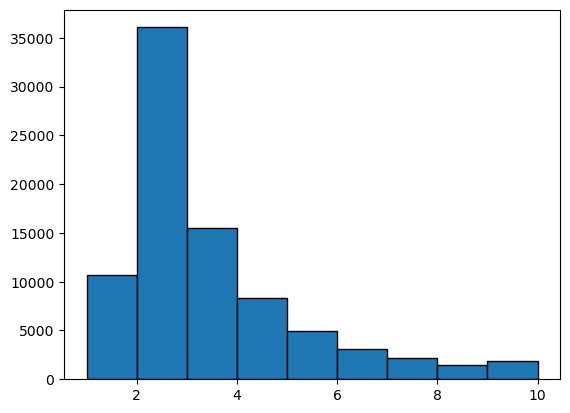

In [23]:
# チャンネルを跨ぐ数を可視化（1つだけ跨ぐとかも見えるからあんまり意味ないな...）
X_modified2 = np.zeros((32, X_modified.shape[1]))
for i in range(X_modified.shape[0]):
    channel = channels[i]
    X_modified2[channel] += X_modified[i]
X_modified2[X_modified2 > 0] = 1
    
X_sum2 = np.sum(X_modified2, axis=0)
# こんな感じかしらね
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.hist(X_sum2, bins=np.arange(10)+1, histtype='barstacked', ec='black')
plt.show()

In [59]:
def output_html_recommend(videos, indexes):
    html = ''
    html += '<div style="float:left;">'
    # html += 'source: '
    html += ('<img src="'+np.array(videos['Thumbnail'])[indexes[0]] +' "alt="取得できませんでした" width="200">')
    html += ' → '
    for i in indexes[1:]:
        html += ('<img src="'+np.array(videos['Thumbnail'])[i] +' "alt="取得できませんでした" width="200">')
        # html += ('<a href="https://www.youtube.com/watch?v='+np.array(videos['Id'])[i]+'">#'+str(i)+'. '+np.array(videos['Title'])[i]+'</a>')
    html += '</div>'
    return html

recommend_ids1 = [182, 46, 288]
recommend_ids2 = [219, 460, 342]

In [60]:
HTML(output_html_recommend(holo_comments, recommend_ids1))

In [58]:
HTML(output_html_recommend(holo_comments, recommend_ids2))

/Users/shinkaitomomichi/opt/anaconda3/envs/study-youtube/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/Users/shinkaitomomichi/opt/anaconda3/envs/study-youtube/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


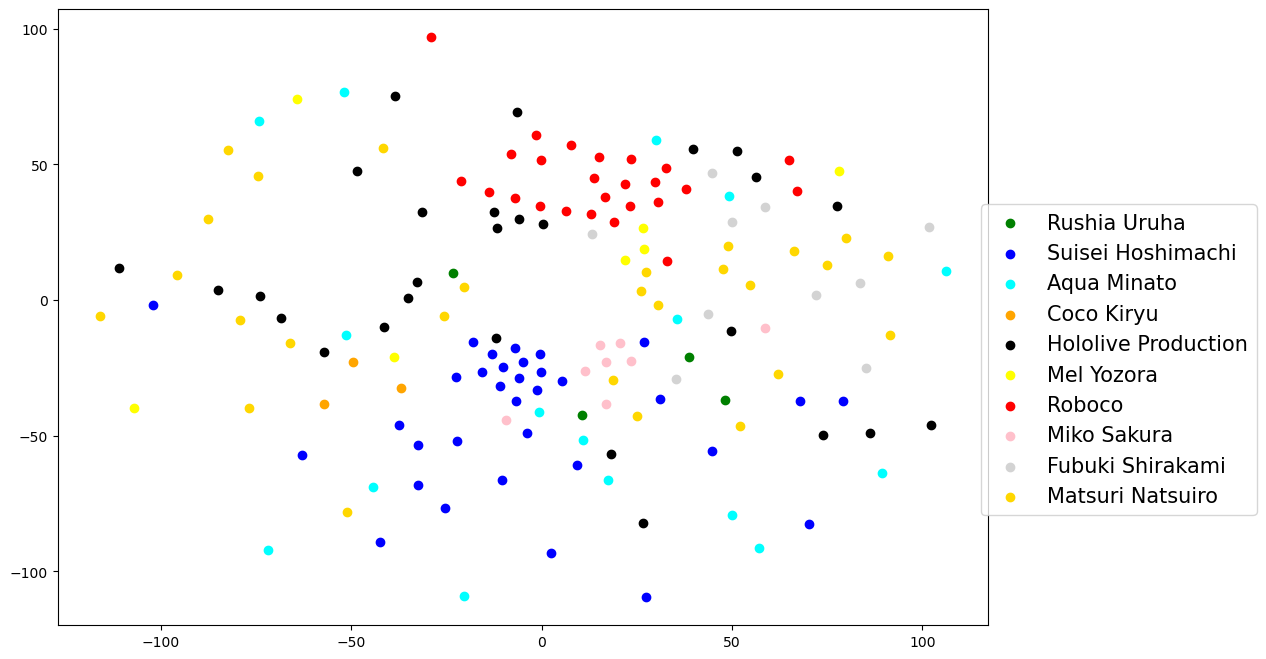

In [56]:
# t-sneでチャンネルごとに可視化
tsne = TSNE(n_components=2, random_state = 0, perplexity = 30, n_iter = 1000)
X_embedded = tsne.fit_transform(X_modified)

ddf = pd.DataFrame(X_embedded, columns = ['col1', 'col2'])
channels = np.array(holo_comments['ChannelModified'])

scat_x, scat_y = np.array(ddf['col1']), np.array(ddf['col2'])
channel_names = ['Rushia Uruha', 'Suisei Hoshimachi', 'Aqua Minato', 'Coco Kiryu', 'Hololive Production', 'Mel Yozora', 'Roboco', 'Miko Sakura', 'Fubuki Shirakami', 'Matsuri Natsuiro']
colors =  ["g", "b", "aqua", "orange", "k", "yellow", "red", "pink", "lightgray", "gold"]
plt.figure(figsize = (12, 8))
for i in range(10, 20):
    # color=colors[i]
    plt.scatter(scat_x[channels==i], scat_y[channels==i], label=channel_names[i-10], color=colors[i-10])
plt.legend(loc='upper right',
           bbox_to_anchor=(1.3, 0.7, 0, 0), 
           fontsize=15)
plt.show()

In [26]:
for i, row in holo_comments.iterrows():
    if row['ChannelModified'] == 13:
        print(row['ChannelModified'], row['Channel'])

13 Coco Ch. 桐生ココ
13 Coco Ch. 桐生ココ
13 Coco Ch. 桐生ココ
